# Data Science Brasil - Desafio Kaggle - Titanic

#### Equipe:
    * Ricardo Galiardi 
    * Wanderson Henrique dos Santos
    * Neri Silvestre Filho

### Datasets

#### Treino
    Columns
        * PassengerId: type should be integers
        * Survived: Survived or Not
        * Pclass: Class of Travel
        * Name: Name of Passenger
        * Sex: Gender
        * Age
        * SibSp: Number of Sibling/Spouse aboard
        * Parch: Number of Parent/Child aboard
        * Ticket
        * Fare
        * Cabin
        * Embarked: The port in which a passenger has embarked. C - Cherbourg, S - Southampton, Q = Queenstown
            
#### Teste
    Columns
        * PassengerId
        * Pclass
        * Name
        * Sex
        * Age
        * SibSp
        * Parch
        * Ticket
        * Fare
        * Cabin
        * Embarked
        
#### Conversões
    Columns
        * Sex:      {'female': 0, 'male': 1}
        * Age:      {"Missing": 0, "Infant": 1, "Child": 2, "Teenager": 3, "Adult": 4, "Senior": 5}
        * Fare:     {"Inferior": 0, "Basic": 1, "Superior": 2, "Executive": 3}
        * Title:    {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
        * Embarked: {'S': 0, 'C': 1, 'Q': 2}
        
#### Envio
    Columns
        * PassengerId: integer
        * Survived: binary

##### Importando xgboost

### Variable Notes
    * survival
        * 0 = No
        * 1 = Yes
    * pclass: A proxy for socio-economic status (SES)
        * 1: 1st = Upper
        * 2: 2nd = Middle
        * 3: 3rd = Lower
    * age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
    * sibsp: The dataset defines family relations in this way...
        * Sibling = brother, sister, stepbrother, stepsister
        * Spouse = husband, wife (mistresses and fiancés were ignored)
    * parch: The dataset defines family relations in this way...
        * Parent = mother, father
        * Child = daughter, son, stepdaughter, stepson
        * Some children travelled only with a nanny, therefore parch=0 for them.
    * embarked: 
        * C = Cherbourg
        * Q = Queenstown
        * S = Southampton  

In [ ]:
!pip install xgboost
#!pip3 install --force-reinstall scikit-learn==0.20rc1

In [ ]:
# Lista os arquivos

import os
print(os.listdir())

##### Preparação dos Dados

In [1]:
# Importando os módulos

import numpy as np
import pandas as pd      
import matplotlib.pyplot as plt   
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import Functions as fn
%matplotlib inline       

In [2]:
# Prepara os datasets

dstrain = pd.read_csv('train.csv', names=['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], sep=',', header=0, dtype={'Age': np.float64})
dstest  = pd.read_csv('test.csv',  names=['PassengerId',             'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], sep=',', header=0, dtype={'Age': np.float64})
dsfull = [dstrain, dstest]

In [3]:
# Copy Dataframes

dstraincopy = dstrain.copy()
dstestcopy  = dstest.copy()

In [4]:
# Verificando os primeiros registros

dstrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Verificando se existem valores nulos e constituição das variáveis.

#Pclass
print('#Pclass')
print (dstrain[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())
print('\n')

#Sex
print('#Sex')
print (dstrain[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())
print('\n')

#SibSp and Parch
print('#SibSp and #Parch')
for dataset in dsfull:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
print('Size')
print (dstrain[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

for dataset in dsfull:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
print('Alone')
print (dstrain[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())
print('\n')

#Embarked
print('#Embarked')
for dataset in dsfull:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
print (dstrain[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())
print('\n')

#Fare
print('#Fare')
for dataset in dsfull:
    dataset['Fare'] = dataset['Fare'].fillna(dstrain['Fare'].median())
    
dstrain['CategoricalFare'] = pd.qcut(dstrain['Fare'], 4)
print (dstrain[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())
print('\n')

#Age
print('#Age')
for dataset in dsfull:
    age_avg 	   = dataset['Age'].mean()
    age_std 	   = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
dstrain['CategoricalAge'] = pd.cut(dstrain['Age'], 5)
print (dstrain[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())
print('\n')

#Name
print('#Name')
for dataset in dsfull:
    dataset['Title'] = dataset['Name'].apply(fn.getTitle)

print(pd.crosstab(dstrain['Title'], dstrain['Sex']))

for dataset in dsfull:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (dstrain[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())
print('\n')

#Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


#Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908


#SibSp and #Parch
Size
   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000
Alone
   IsAlone  Survived
0        0  0.505650
1        1  0.303538


#Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


#Fare
   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


#Age
  CategoricalAge  Survived
0  (-0.08, 16.0]  0.500000
1   (16.0, 32.0]  0.349887
2   (32.0, 48.0]  0.389764
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


#Name
Sex       female  male
Title                 
Capt           0     1
Col            0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
# Normalizar

for dataset in dsfull:
    # Mapping Sex
    fn.setSex(dataset, 'Sex')
    
    # Mapping titles
    fn.setTitle(dataset, 'Title')
    
    # Mapping Embarked
    fn.setEmbarked(dataset, 'Embarked')
    
    # Mapping Fare
    fn.setFare(dataset, 'Fare')
    
    # Mapping Age
    fn.setAge(dataset, 'Age')

# Copy Normalization
dscopy = dstrain.copy()

# Feature Selection
#drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'FamilySize']
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'FamilySize']
dstrain = dstrain.drop(drop_elements, axis = 1)
dstrain = dstrain.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
dstest  = dstest.drop(drop_elements, axis = 1)

print (dstrain.head(10))

dsresult = dstrain.copy()
#dstrain = dstrain.values
#dstest  = dstest.values

   PassengerId  Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0            1         0       3    1  4.0   0.0         0        0      1
1            2         1       1    0  5.0   0.0         1        0      3
2            3         1       3    0  4.0   1.0         0        1      2
3            4         1       1    0  4.0   0.0         0        0      3
4            5         0       3    1  4.0   1.0         0        1      1
5            6         0       3    1  5.0   1.0         2        1      1
6            7         0       1    1  5.0   0.0         0        1      1
7            8         0       3    1  1.0   2.0         0        0      4
8            9         1       3    0  4.0   1.0         0        0      3
9           10         1       2    0  3.0   2.0         1        0      3


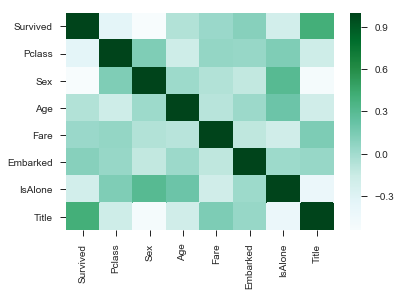

In [7]:
# Visualizando a correlação em tabela

# Coeficiente de correlação: 
# +1  = forte correlação positiva
# 0   = não há correlação
# -1  = forte correlação negativa
fn.corr(dsresult.iloc[::, 1::])

##### Exploração dos Dados

In [ ]:
# Verifica a relação entre a variável preditora x as independentes

#fn.plot(dsresult, 'Survived', 'Pclass')
#fn.plot(dsresult, 'Survived', 'Sex')
#fn.plot(dsresult, 'Survived', 'Age')
#fn.plot(dsresult, 'Survived', 'Fare')
#fn.plot(dsresult, 'Survived', 'Embarked')
fn.plot(dsresult, 'Survived', 'IsAlone')
#fn.plot(dsresult, 'Survived', 'Title')

In [8]:
# Importação dos classificadores

# Suprime erros
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [30]:
dstrain.iloc[0::, 1::].head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,0,3,1,4.0,0.0,0,0,1
1,1,1,0,5.0,0.0,1,0,3
2,1,3,0,4.0,1.0,0,1,2
3,1,1,0,4.0,0.0,0,0,3
4,0,3,1,4.0,1.0,0,1,1


In [53]:
# Comparação dos classificadores

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100, oob_score = True),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    XGBClassifier()]

splits = 11
cols = ["Classifier", "Accuracy"]
acc_dict = {}
log = pd.DataFrame(columns=cols)
count = 0

X = dstrain.iloc[0::, 2::].values
y = dstrain.iloc[0::, 1].values

#shuff = KFold(n_splits=splits, random_state=42, shuffle=True)
shuff = ShuffleSplit(n_splits=splits, test_size=0.3, random_state=0)
#shuff = StratifiedShuffleSplit(n_splits=splits, test_size=0.4, random_state=0)

for train_index, test_index in shuff.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        count += 1
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=cols)
    log = log.append(log_entry)
    
acc_dict

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

121

In [54]:
acc_dict

{'KNeighborsClassifier': 0.8563432835820896,
 'SVC': 0.8794776119402986,
 'DecisionTreeClassifier': 0.8783582089552239,
 'RandomForestClassifier': 0.8805970149253731,
 'AdaBoostClassifier': 0.882089552238806,
 'GradientBoostingClassifier': 0.9011194029850748,
 'GaussianNB': 0.8492537313432835,
 'LinearDiscriminantAnalysis': 0.8645522388059701,
 'QuadraticDiscriminantAnalysis': 0.8608208955223879,
 'LogisticRegression': 0.8735074626865673,
 'XGBClassifier': 0.9029850746268657}

,
Classifier,Accuracy
XGBClassifier,0.895506
GradientBoostingClassifier,0.887640
AdaBoostClassifier,0.880899
SVC,0.879401
RandomForestClassifier,0.875281
LogisticRegression,0.873783
LinearDiscriminantAnalysis,0.869663
DecisionTreeClassifier,0.869288
QuadraticDiscriminantAnalysis,0.867041


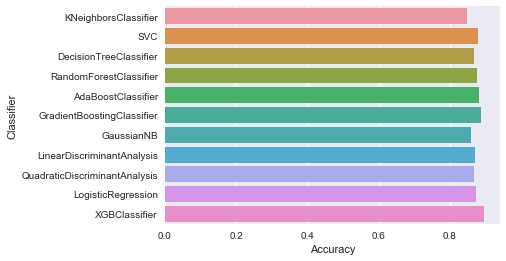

In [46]:
# Plot Classifier Accuracy

sns.set(style="darkgrid")
sns.barplot(x='Accuracy', y='Classifier', data=log)

log.groupby(['Classifier', 'Accuracy']).count().sort_values(by=['Accuracy'], ascending=False)

In [51]:
# Prediction

classifier = SVC()
classifier.fit(X_train, y_train)
predictions = classifier.predict(dstest)

ValueError: X.shape[1] = 8 should be equal to 7, the number of features at training time

In [ ]:
# Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

print('Confusion Matrix')
predictions = cross_val_predict(classifier, X_train, y_train, cv=3)
pd.DataFrame(confusion_matrix(y_train, predictions), columns=['true', 'false'], index=['true', 'false'])

In [ ]:
# Create csv to upload to Kaggle

#Create a  DataFrame with the passengers ids and our prediction regarding whether they survived or not
dssubmission = pd.DataFrame({'PassengerId': dstestcopy['PassengerId'], 'Survived': predictions})

In [ ]:
#Visualize the first 5 rows

dssubmission.groupby(['Survived'])['Survived'].sum()

In [ ]:
dssubmission.groupby(['Survived'])['Survived'].count()

In [ ]:
fn.plot(dssubmission, 'Survived', 'Survived')

In [ ]:
#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'kaggle_titanic.csv'

dssubmission.to_csv(filename, index=False)